# Load CSV Data into Numpy

In [1]:
import csv
import os
import numpy as np

path = 'demoDataset/4_18_24/'
files = os.listdir(path)
dataFiles = []
for file in files:
  if file.split(".")[-1] == "csv":
    dataFiles.append(file)
data = {}
for dataFile in dataFiles:
    with open(path + dataFile, 'r') as csvfile:
        csvReader = csv.DictReader(csvfile, fieldnames=['time', 'id', 'x_acc',
                                                     'y_acc', 'z_acc', 'x_rot', 'y_rot',
                                                     'z_rot', '', '', '', '', '', '', '', 'x_pos', 'y_pos', 'heading'])
        # load as specified in readme.txt
        features = []
        for row in csvReader:
            if row["id"] != "6":
               print("ID", row["id"])
               continue 
            features.append(
                [
                    float(row["time"]),  # 0
                    float(row["id"]),  # 1
                    float(row["x_acc"]),  # 2
                    float(row["y_acc"]),  # 3
                    float(row["z_acc"]),  # 4
                    float(row["x_rot"]),  # 5
                    float(row["y_rot"]),  # 6
                    float(row["z_rot"]),  # 7
                    float(row["x_pos"]),  # 8
                    float(row["y_pos"]),  # 9
                    float(row["heading"]),
                ]
            )  # 10
        features = np.array(features) # num of samples x features (11)
        data[dataFile.split(".")[0]] = features  # index data by file name

data

{'randomPath': array([[ 2.69728184e-01,  6.00000000e+00,  0.00000000e+00, ...,
          2.87218045e+01,  3.01724138e+01,  6.02951121e+00],
        [ 3.36018324e-01,  6.00000000e+00,  0.00000000e+00, ...,
          7.50000000e+01, -1.38000000e+02,  6.02951121e+00],
        [ 3.49452734e-01,  6.00000000e+00,  0.00000000e+00, ...,
          2.87218045e+01,  3.01724138e+01,  6.02951121e+00],
        ...,
        [ 2.52949238e+01,  6.00000000e+00,  1.10000000e-01, ...,
          4.71910112e+01,  2.73775216e+01,  6.80521225e-01],
        [ 2.53653667e+01,  6.00000000e+00,  1.00000000e-01, ...,
          4.72180451e+01,  2.74425287e+01,  6.80521225e-01],
        [ 2.53943610e+01,  6.00000000e+00,  1.00000000e-01, ...,
          4.71910112e+01,  2.73775216e+01,  6.80521225e-01]]),
 'headingRot': array([[ 2.69700766e-01,  6.00000000e+00,  8.00000000e-02, ...,
          4.34586466e+01,  2.75862069e+01,  2.11093333e-01],
        [ 3.41224194e-01,  6.00000000e+00,  1.30000000e-01, ...,
         -

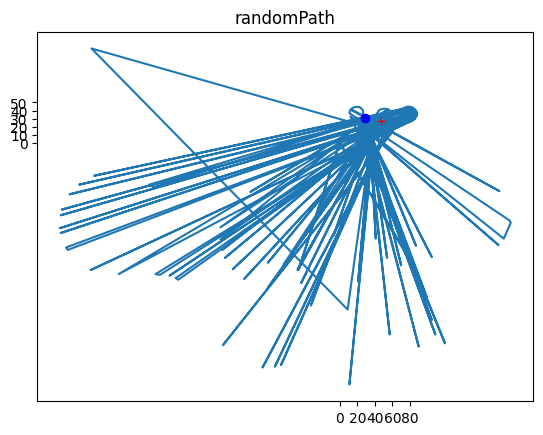

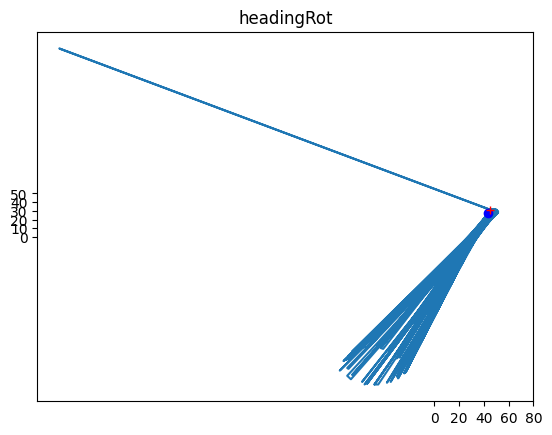

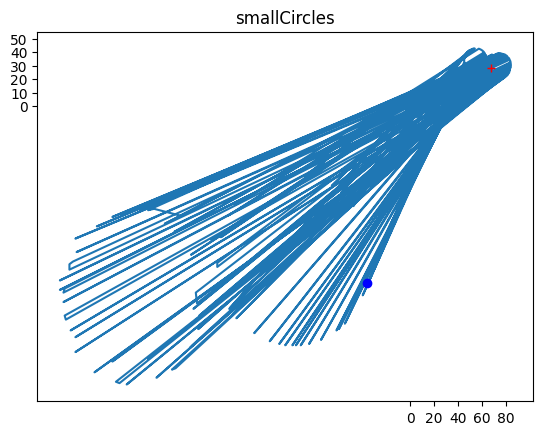

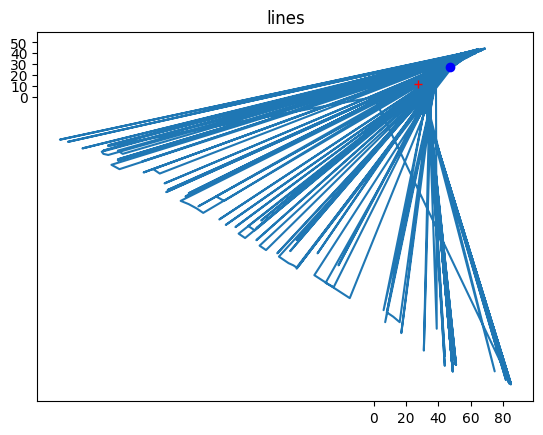

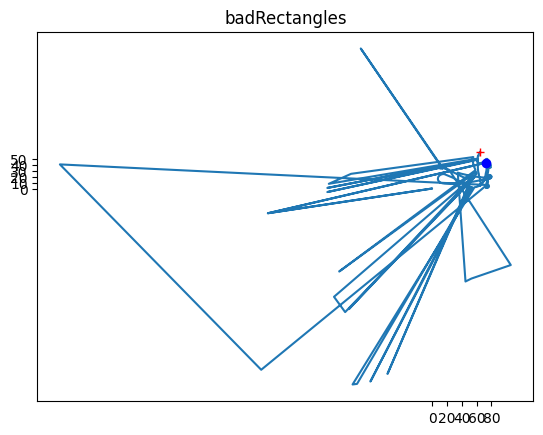

In [2]:
import matplotlib.pyplot as plt

for item in data:
    plt.plot(
        *data[item][:, [8, 9]].transpose()
    )  # get ground truth x & y, transpose from list of points to two lists of x & y, cm
    plt.plot(*data[item][0, [8, 9]].transpose(), "bo")
    plt.plot(*data[item][data[item].shape[0] - 1, [8, 9]].transpose(), "r+")
    plt.xticks(range(0, 90, 20))
    plt.yticks(range(0, 60, 10))
    plt.title(item)
    plt.show()

# Clean Data

In [326]:
from scipy.interpolate import interp1d

for item in data:

    # remove deviant data from tracking loss
    x_pos = data[item][:, 8]
    y_pos = data[item][:, 9]
    x_mean = np.mean(x_pos, axis=0)
    y_mean = np.mean(y_pos, axis=0)
    x_sd = np.std(x_pos, axis=0)
    y_sd = np.std(y_pos, axis=0)
    dev_rows = []
    x_prev, y_prev = (data[item][0, 8], data[item][0,9])
    for i in range(data[item].shape[0]):
        x_pos = data[item][i, 8]
        y_pos = data[item][i, 9]
        if x_pos <= 0 or y_pos <= 0:
            dev_rows.append(i)
            continue
        if i != 0:
            if abs(x_pos - x_prev) > 5 or abs(y_pos - y_prev) > 5:
                print(abs(x_pos - x_prev), abs(y_pos - y_prev))
                dev_rows.append(i)
        x_prev = x_pos
        y_prev = y_pos
        # remove values two standard devations from norm
        if x_pos < x_mean - x_sd * 2:
            dev_rows.append(i)
        elif x_pos > x_mean + x_sd * 2:
            dev_rows.append(i)
        if y_pos < y_mean - y_sd * 2:
            dev_rows.append(i)
        elif y_pos > y_mean + y_sd * 2:
            dev_rows.append(i)
    print(data[item][:, 0].shape, data[item][:, [8, 9]].shape)
    data[item] = np.delete(data[item], dev_rows, axis=0) # delete row
    # interpolate data for smoothness
    print(data[item][:, 0].shape, data[item][:, [8, 9]].shape)
    interp = interp1d(np.unique(data[item][:, 0]), data[item].transpose(), kind="cubic")
    interp_data = interp(np.linspace(data[item][0, 0], data[item][0, 0], 1000)).transpose()
    data[item] = np.vstack([data[item], interp_data])
    data[item] = data[item][data[item][:, 0].argsort()] # sort by time

5.0936329588015 1.2676518883415433
randomPath
(671,) (671, 2)
(596,) (596, 2)
headingRot
(324,) (324, 2)
(270,) (270, 2)
81.3932584269663 162.12391930835736
smallCircles
(501,) (501, 2)
(401,) (401, 2)
5.0936329588015 5.120689655172413
5.226549519867085 4.702791461412151
4.799597518027831 5.01432664756447
lines
(397,) (397, 2)
(280,) (280, 2)
11.601391538547865 4.741379310344829
3.2215327855106466 5.764927375870123
5.314998043490405 2.7298850574712645
1.0486891385767763 11.637931034482762
6.501201855889079 1.4765311868561408
6.195713163505772 1.152737752161384
16.456481636760014 1.724137931034484
11.131980546704675 5.890804597701152
15.522388059701491 10.632183908045974
0.2996254681647912 13.92974262148465
badRectangles
(730,) (730, 2)
(698,) (698, 2)


In [327]:
interp([1,2])

array([[ 1.00000000e+00,  2.00000000e+00],
       [ 6.00000000e+00,  6.00000000e+00],
       [ 1.64908295e-01,  1.18021442e-01],
       [-1.48490386e-02, -7.39158164e-02],
       [ 9.77282827e+00,  9.78698496e+00],
       [-1.76450836e-29,  2.66897787e-14],
       [ 1.28065035e-28, -1.93709904e-13],
       [-4.89337318e-28,  7.40166783e-13],
       [ 7.30276282e+01,  7.30297897e+01],
       [ 4.39667339e+01,  4.39655172e+01],
       [-1.12816575e-01, -3.28648743e-02]])

# Plot Overall Data

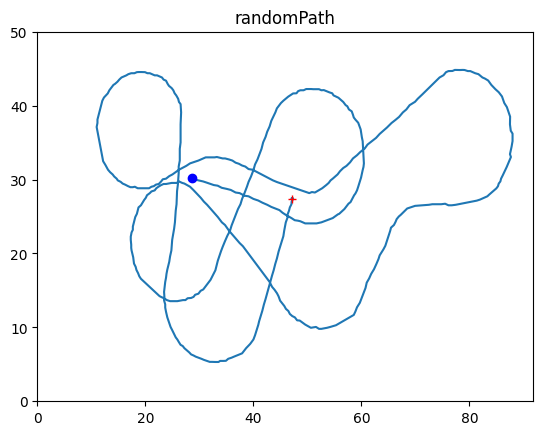

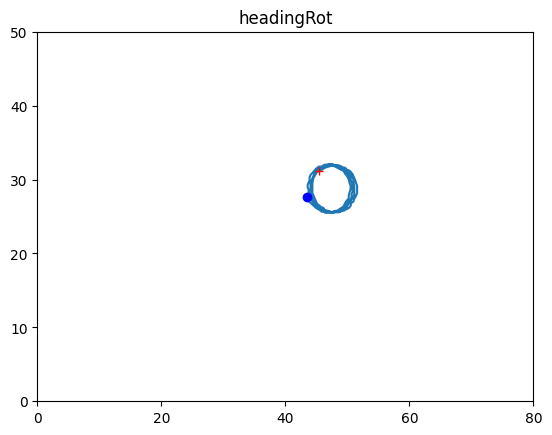

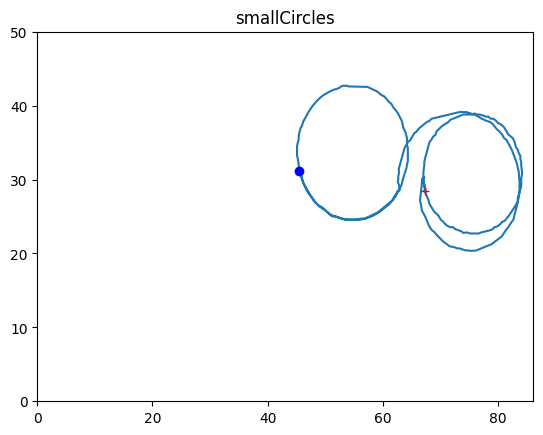

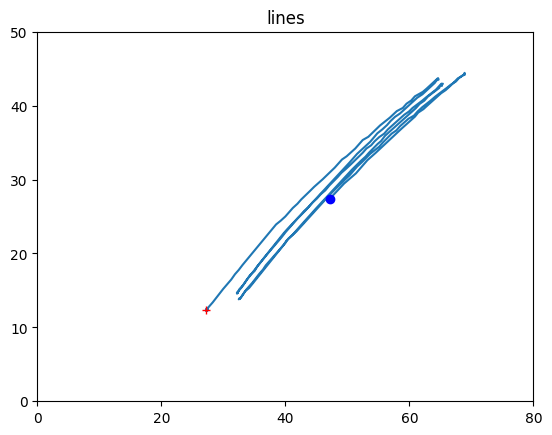

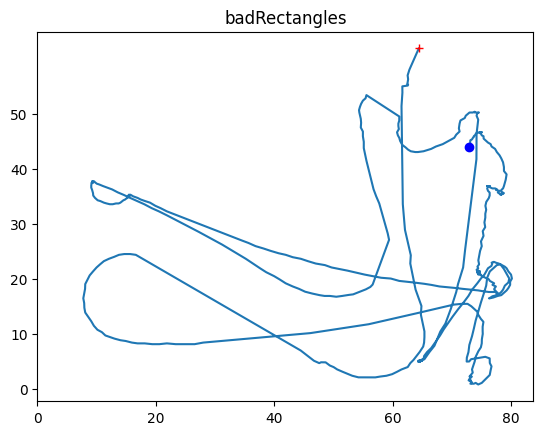

In [328]:
import matplotlib.pyplot as plt
for item in data:
    plt.plot(
        *data[item][:, [8, 9]].transpose()
    )  # get ground truth x & y, transpose from list of points to two lists of x & y, cm
    plt.plot(*data[item][0, [8,9]].transpose(), 'bo')
    plt.plot(*data[item][data[item].shape[0]-1, [8, 9]].transpose(), 'r+')
    plt.xticks(range(0, 90, 20))
    plt.yticks(range(0, 60, 10))
    plt.title(item)
    plt.show()

# Animate Data

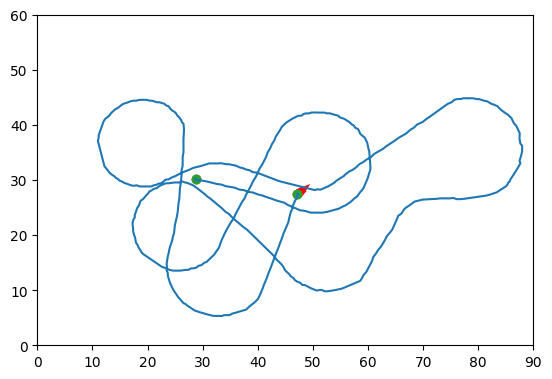

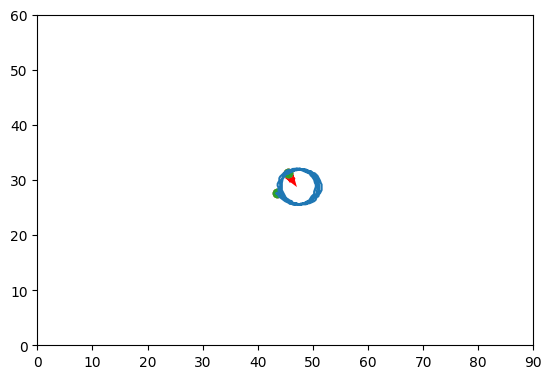

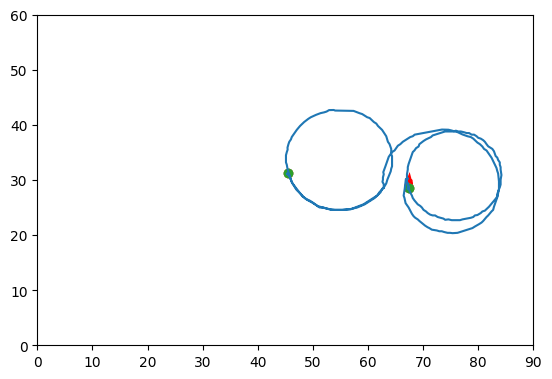

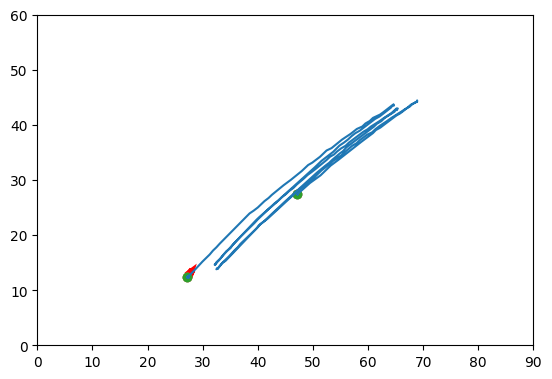

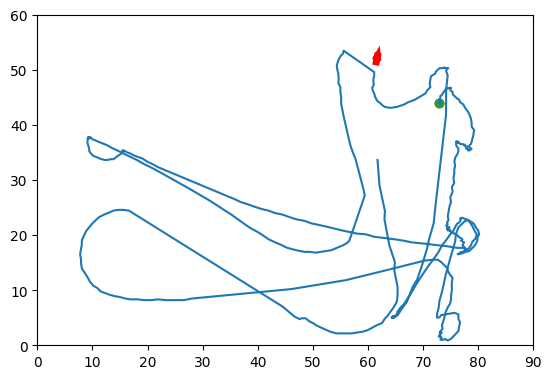

In [346]:
from matplotlib import animation
from matplotlib import transforms

for item in data:
    currentData = data[item]

    duration = currentData[currentData.shape[0]-1, 0] # extract time codes
    timeSamples = np.linspace(0, int(duration), int(60*duration)) # generate time values
    frames = []
    for timeSample in timeSamples: # best fit time values to time values in data
        frames.append((np.abs(currentData[:, 0] - timeSample)).argmin())

    fig = plt.figure()
    plt.axis([0, 90, 0, 60])
    ax = plt.gca()
    ax.set_aspect(1)
    (line,)  = plt.plot([], [])
    arrow = plt.arrow(0, 0, 0, 0, linewidth=5.0, color='red')
    def init():
        line.set_data([], [])
        plt.scatter(
            [currentData[0, 8], currentData[currentData.shape[0] - 1, 8]],
            [currentData[0, 9], currentData[currentData.shape[0] - 1, 9]],
        )
        return (line,)

    def animate(i):
        line.set_data(
            currentData[0:i, 8], currentData[0:i, 9]
        )
        x = currentData[i, 8]
        y = currentData[i, 9]
        theta = currentData[i, 10]
        arrow.set_data(x=x, y=y, dx=np.cos(theta), dy=np.sin(theta))
        return (arrow,line)

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=frames, interval=15, blit=True
    )
    with open(item+".html", "w") as f:
        print(anim.to_html5_video(), file=f)  